# Week 13: Image search and classification using Deep learning

According to the experiment in paper ImageNet Classification with Deep Convolutional Neural Networks  (Links to an external site.), we can design a convolutional neural network to classify an image into a specific class.

More importantly, given any input image, the corresponding feature vector learned from the last hidden layer of the CNN can be used to find similar images in the training data set by calculating the Euclidean distance between any two feature vectors. In the last section, we will develop an image searching engine

Therefore, the feature vectors derived from the deep learning network can also be used for image searching.

We will extend our algorithms to develop an image search web server.

## Part 1.  Design a convolutional neural network for image classification


### Step 1: Data Loading
First of all, we can work on the popular dataset called 'CIFAR10', containing 32x32 color images of 10 categories of objects. Below are labels for the objects - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

We can directly load the dataset into memory from module 'keras.datasets,' which contains:

Training Set: 50000 images, dimension shape: 50000 * 32 * 32 *3

Test Set: 10000 images, dimension shape: 10000 * 32 * 32 *3

In [1]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

labels_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
print("X_train.shape: ", X_train.shape,"\n","y_train.shape:", y_train.shape, "\n","X_test.shape:", X_test.shape, "\n","y_test.shape:", y_test.shape)

X_train.shape:  (50000, 32, 32, 3) 
 y_train.shape: (50000, 1) 
 X_test.shape: (10000, 32, 32, 3) 
 y_test.shape: (10000, 1)


### Step 2: Data Visualization

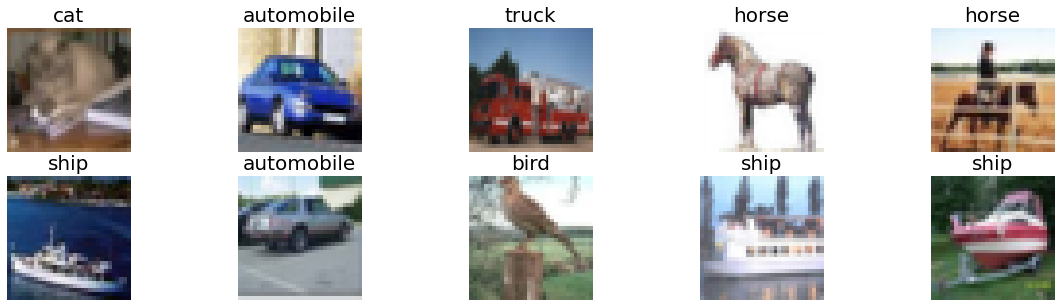

In [2]:
fig = plt.figure(figsize=(20, 5))

for ii in range(10):
   jj = np.random.choice(range(len(X_train))) # randomly choose one image
   label = [labels_map[j] for j in y_train[jj]][-1]  # get its label
   imgplot = fig.add_subplot(2,5,ii+1)  ## set up grid of 2 rows and 5 columns for visualization
   imgplot.imshow(X_train[jj]) # visualize the image
   imgplot.set_title(label, fontsize=20) # set the title
   imgplot.axis('off')

### Step 3: Define model: Train the CNN network (use GPU on Google Colab)

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D
from keras import regularizers
from keras.layers import Flatten,BatchNormalization,Dropout


model = Sequential() # create Sequential model

### Step 4:  Feature scaling before feeding into the CNN

In [4]:
num_classes = len(labels_map)
from keras.utils.np_utils import to_categorical

## Step 4.1: convert to one-hot encoding for classification
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes) 

## Step 4.2: Feature Min-Max normalization
X_train_s = X_train.astype('float32')/255
X_test_s = X_test.astype('float32')/255


In [5]:
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_train_s shape", X_train_s.shape)
print("X_test_s shape", X_test_s.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)
print("y_train_categorical shape", y_train_categorical.shape)
print("y_test_categorical shape", y_test_categorical.shape)


X_train shape (50000, 32, 32, 3)
X_test shape (10000, 32, 32, 3)
X_train_s shape (50000, 32, 32, 3)
X_test_s shape (10000, 32, 32, 3)
y_train shape (50000, 1)
y_test shape (10000, 1)
y_train_categorical shape (50000, 10)
y_test_categorical shape (10000, 10)


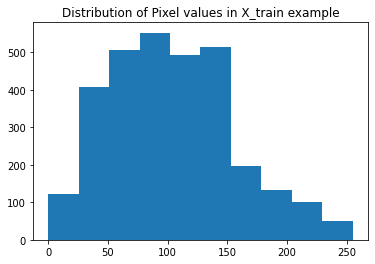

In [6]:
from matplotlib import pyplot as plt 
plt.hist(X_train[0].flatten(),) 
plt.title("Distribution of Pixel values in X_train example") 
plt.show()

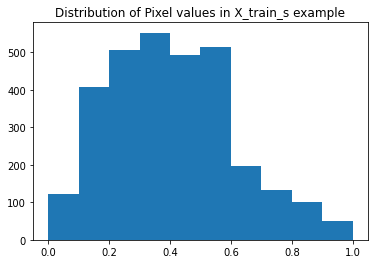

In [7]:
plt.hist(X_train_s[0].flatten(),) 
plt.title("Distribution of Pixel values in X_train_s example") 
plt.show()

### Step 5: Define the CNN architecture

In [8]:
### Step 5.1: Load the Keras class
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,MaxPooling2D
from keras import regularizers
from keras.layers import Flatten,BatchNormalization,Dropout,Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Step 5.2: Define early stop
keras_callbacks = [
 EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001),
 ModelCheckpoint('./checkmodel.h5', monitor='val_loss', save_best_only=True, mode='min')
]


### Step 5.3: Define the CNN architecture

model = Sequential()

### Step 5.3.1: define First convolution block
model.add(Conv2D(81, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))

### Step 5.3.2: define Second convolution block
model.add(Conv2D(81, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

### Step 5.3.3: define Third convolution block
model.add(Conv2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))


### Step 5.3.4: define Fourth convolution block
model.add(Conv2D(96, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

### Step 5.3.5: define flatten layer, this will convert 2D dimension matrix into 1D array for each image
model.add(Flatten())

### Step 5.3.6: define fully-connected layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

### Step 5.3.7:Your task, set appropriate number of hiddhen neurons. This may affect your dimension of feature vectors for image searching
model.add(Dense(81))
model.add(Activation('relu'))

### Step 5.3.8: Define the last classification layer with softmax function
model.add(Dense(num_classes, activation='softmax'))

model.summary()
### Step 5.3.9: compile the model 
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 81)        2268      
                                                                 
 activation (Activation)     (None, 32, 32, 81)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 81)        59130     
                                                                 
 activation_1 (Activation)   (None, 30, 30, 81)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 81)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 81)        0         
                                                      

### Step 6: Start training the CNN model

In [24]:
history_log = model.fit(X_train_s, y_train_categorical, validation_split=0.1, batch_size=64, epochs = 30, callbacks=keras_callbacks)

Epoch 1/30
704/704 [==============================] - 26s 33ms/step - loss: 1.6053 - accuracy: 0.4079 - val_loss: 1.2516 - val_accuracy: 0.5442
Epoch 2/30
704/704 [==============================] - 23s 32ms/step - loss: 1.1627 - accuracy: 0.5868 - val_loss: 0.9478 - val_accuracy: 0.6604
Epoch 3/30
704/704 [==============================] - 23s 33ms/step - loss: 0.9730 - accuracy: 0.6537 - val_loss: 0.8696 - val_accuracy: 0.6982
Epoch 4/30
704/704 [==============================] - 22s 31ms/step - loss: 0.8534 - accuracy: 0.6997 - val_loss: 0.7966 - val_accuracy: 0.7220
Epoch 5/30
704/704 [==============================] - 23s 32ms/step - loss: 0.7736 - accuracy: 0.7286 - val_loss: 0.7286 - val_accuracy: 0.7404
Epoch 6/30
704/704 [==============================] - 23s 32ms/step - loss: 0.7204 - accuracy: 0.7475 - val_loss: 0.7069 - val_accuracy: 0.7614
Epoch 7/30
704/704 [==============================] - 22s 32ms/step - loss: 0.6652 - accuracy: 0.7672 - val_loss: 0.6661 - val_accuracy:

In [9]:
from google.colab import drive
drive.mount('/content/drive/')

from tensorflow.python.keras.models import save_model,load_model
# import shutil


Mounted at /content/drive/


In [ ]:

path="/content/drive/MyDrive/Models/wk_13_cnn.h5"
save_model(model,path)

In [12]:
path="/content/drive/MyDrive/Models/wk_13_cnn.h5"
trained_model = load_model(path)

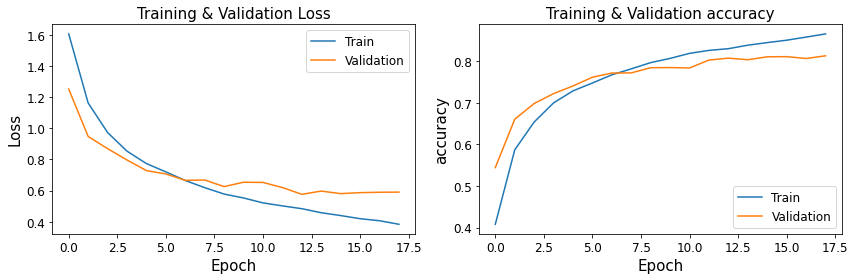

In [49]:
# Step 11.2:  Plot the learning curves for training/validation
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# Plot training & validation loss values
plt.plot(history_log.history['loss'], label='Train')
plt.plot(history_log.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.subplot(1,2,2)
# Plot training & validation accuracy values
plt.plot(history_log.history['accuracy'], label='Train')
plt.plot(history_log.history['val_accuracy'], label='Validation')
plt.title('Training & Validation accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)

plt.xlabel('Epoch', fontsize=15)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

### Step 7: Evaluate the CNN model

In [11]:
score_train = trained_model.evaluate(X_train_s, y_train_categorical, verbose=0)

[0.19970202445983887, 0.9416800141334534]

In [13]:
# Task: write codes to evaluate the classification accuracy in training set and testing set. Copy/paste your codes here, and report the accuracy results.

# score_train = model.evaluate(X_train_s, y_train_categorical, verbose=0)
score_train = trained_model.evaluate(X_train_s, y_train_categorical, verbose=0)

# score = model.evaluate(X_test_s, y_test_categorical, verbose=0)
score = trained_model.evaluate(X_test_s, y_test_categorical, verbose=0)

print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])

print('Test score:', score[0])
print('Test accuracy:', score[1])

Train score: 0.19970202445983887
Train accuracy: 0.9416800141334534
Test score: 0.6469122171401978
Test accuracy: 0.7954000234603882


In [15]:
trained_model.summary()
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 81)        2268      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 81)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 81)        59130     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 81)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 81)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 81)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 96)        7

In [25]:
### Step 8.1: get all layers of the model and save into a list 
model_layers = model.layers
print(model_layers)

[<keras.layers.convolutional.Conv2D object at 0x7f7c1f62fe50>, <keras.layers.core.activation.Activation object at 0x7f7c10172e10>, <keras.layers.convolutional.Conv2D object at 0x7f7c100c5510>, <keras.layers.core.activation.Activation object at 0x7f7c100c59d0>, <keras.layers.pooling.MaxPooling2D object at 0x7f7c10081590>, <keras.layers.core.dropout.Dropout object at 0x7f7c10172e90>, <keras.layers.convolutional.Conv2D object at 0x7f7c101d7cd0>, <keras.layers.core.activation.Activation object at 0x7f7c1e7ff690>, <keras.layers.convolutional.Conv2D object at 0x7f7c10085890>, <keras.layers.core.activation.Activation object at 0x7f7c1ea2db10>, <keras.layers.pooling.MaxPooling2D object at 0x7f7c10033550>, <keras.layers.core.dropout.Dropout object at 0x7f7c1008d9d0>, <keras.layers.core.flatten.Flatten object at 0x7f7c10023fd0>, <keras.layers.core.dense.Dense object at 0x7f7c1003dfd0>, <keras.layers.core.activation.Activation object at 0x7f7c100333d0>, <keras.layers.core.dropout.Dropout object a

In [27]:
###Step 8.2: Let's select last second layer as the output for feature extractor 
# model.layers[-2].output corresponds to the output of last second layer 
print(trained_model.layers[-2].output)


###Step 8.3: Let's select the first layer as the input of feature extractor 
# model.layers[0].input corresponds to the input of the first layer 
print(trained_model.layers[0].input)

KerasTensor(type_spec=TensorSpec(shape=(None, 81), dtype=tf.float32, name=None), name='activation_5/Relu:0', description="created by layer 'activation_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


In [28]:
###Step 8.3: Then we can build a feature extractor function to map the input to feature vectors
from keras import backend as K
Get_Hidden_Layered_Output = K.function([model.layers[0].input], [model.layers[-2].output])

In [29]:
### Step 8.4: Let's apply the feature extractor on one image, and check the feature vector
image_sample = X_train_s[0].reshape(1,32,32,3)
image_sample_outfeatures = Get_Hidden_Layered_Output(image_sample)[0]

print("extracted_features:", image_sample_outfeatures)
print("shape of original features:", image_sample.shape)
print("shape of extracted features:", image_sample_outfeatures.shape)

extracted_features: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.9602382e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 7.2105856e+00 0.0000000e+00 0.0000000e+00 9.4261169e-03
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7392750e+00
  1.7211491e+00 0.0000000e+00 3.0538023e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0255985e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.7334785e+00 0.0000000e+00 5.3898776e-01 6.6643209e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3853327e-01
  4.4140711e-01 4.1682673e+00 3.5875862e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.7974688e+00 0.0000000e+00 0.0000000e+00 7.0823336e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 5.4747486e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0704975e+00 2.0950408e+00
  0.0000000e+00 3.7743789e-01 0.0000000e+00 

### Step 9: Apply the feature extractor on all training and test images

In [30]:
# Step 9.1: Apply the feature extractor on all training images
X_train_featureVector = []
batch_size = 500 # set batch size to avoid memory issues
for i in range(int(X_train_s.shape[0]/batch_size)):
    X_train_featureVector.append(Get_Hidden_Layered_Output([X_train_s[i*batch_size:(i+1)*batch_size,:,:,:]])[0])

X_train_featureVector = np.concatenate(X_train_featureVector,axis=0)

In [31]:
X_train_featureVector.shape

(50000, 81)

In [32]:
X_test_featureVector = []
batch_size = 500 # set batch size to avoid memory issues
for i in range(int(X_train_s.shape[0]/batch_size)):
    X_test_featureVector.append(Get_Hidden_Layered_Output([X_test_s[i*batch_size:(i+1)*batch_size,:,:,:]])[0])

X_test_featureVector = np.concatenate(X_test_featureVector,axis=0)

X_test_featureVector.shape

(10000, 81)

### Step 10: Design algorithms to find the similar images using euclidean distance.

In [73]:
# 1. Randomly select one image from the test set
# 2. Predict the class for the image
# 3. Get the hidden feature vector for the image
# 4. Calculate the euclidean distance between the hidden feature vector of the image and hidden feature vectors of all images in the training set
# 5. Select the top 10 images that have smallest Euclidean distance
# 6. Visualization of the searching results


In [67]:
from scipy import spatial,stats

def KNN_predict_labels(train_features, train_labels, test_feature, K):
  label_record = []
  for i in range(len(train_features)):
    train_point_feature = train_features[i].astype(int)
    test_point_feature = test_feature

    #print(train_point_feature.shape)
    #print(test_point_feature.shape)

    # get distance for data point i 
    dis = spatial.distance.euclidean(train_point_feature, test_point_feature)
    
    # collect lable for datapoint i 

    y = train_labels[i]
    
    label_record.append((dis, y, i))

  # sort data points by distance 
  from operator import itemgetter
  sorted_labels = sorted(label_record,key=itemgetter(0))
  # get major class from top K neighbors 
  major_class = []
  major_index = []

  #print(sorted_labels)
  for k in range(K):
    major_class.append(sorted_labels[k][1])
    major_index.append(sorted_labels[k][2])

    # print(major_index)

  # return the prediction using majority of class
  final_prediction = stats.mode(major_class).mode[0]
  #print("Prediction: ",final_prediction)
  return final_prediction, major_index


In [56]:
len(X_train_featureVector)

50000

In [57]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [119]:
ind = np.random.choice(range(len(X_test)))

label,closest_images = KNN_predict_labels(X_train_featureVector,y_train,X_test_featureVector[ind], 10)
label[0]

[17062]
[17062, 41866]
[17062, 41866, 9670]
[17062, 41866, 9670, 7253]
[17062, 41866, 9670, 7253, 33289]
[17062, 41866, 9670, 7253, 33289, 6602]
[17062, 41866, 9670, 7253, 33289, 6602, 25315]
[17062, 41866, 9670, 7253, 33289, 6602, 25315, 41330]
[17062, 41866, 9670, 7253, 33289, 6602, 25315, 41330, 845]
[17062, 41866, 9670, 7253, 33289, 6602, 25315, 41330, 845, 37204]


3

In [121]:
labels_map[label[0]]

'cat'

Text(0.5, 1.0, 'Actual figure: cat')

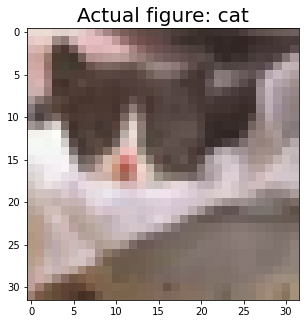

In [122]:
fig = plt.figure(figsize=(20, 5))

imgplot = fig.add_subplot(1,1,1)
label = labels_map[y_test[ind][0]]
imgplot.imshow(X_test[ind])
imgplot.set_title("Actual figure: "+label, fontsize=20)


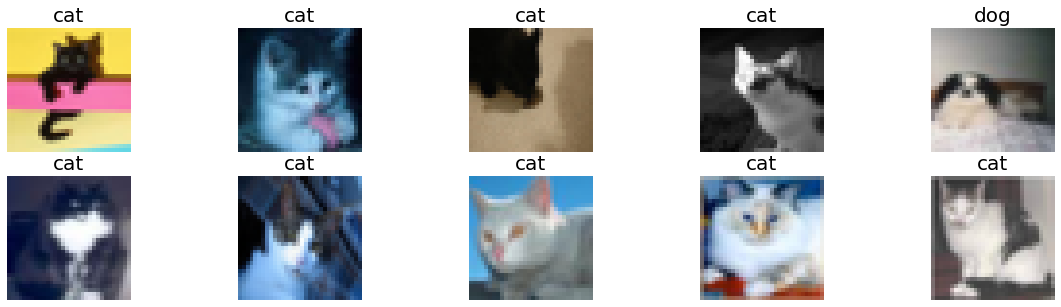

In [123]:
fig = plt.figure(figsize=(20, 5))

for ind,val in enumerate(closest_images):
  label = labels_map[y_train[val][0]]
  imgplot = fig.add_subplot(2,5,ind+1)  ## set up grid of 2 rows and 5 columns for visualization
  imgplot.imshow(X_train[val]) # visualize the image
  imgplot.set_title(label, fontsize=20) # set the title
  imgplot.axis('off')
